# Lottery Ticket Hypothesis: _LeNet_ Dense Fully-Connected Feed Forward Neural Network for MNIST

Implementation of the hypothesis using the following architecture:

__Fully Connected Layers:__ 300, 100, 10

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [5]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train.shape = (60000, 10)
X_test.shape = (10000, 784), y_test.shape = (10000, 10)


### Prepare MNIST dataset for _GradientTape_ training:

In [11]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [13]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [14]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0012)

In [15]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [16]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  100000


In [17]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [18]:
l = tf.keras.layers

In [19]:
def pruned_nn(pruning_params):
    """
    Function to define the architecture of a neural network model
    following 300 100 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    pruned_model.add(l.InputLayer(input_shape=(784, )))
    pruned_model.add(Flatten())
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 300, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.2))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 100, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.1))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = num_classes, activation='softmax'),
        **pruning_params))
    
    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy'])
    
    return pruned_model


In [20]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [21]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [22]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [23]:
# Save random weights-
orig_model.save_weights("LeNet_MNIST_Ramdom_Weights.h5", overwrite=True)

In [24]:
# Save random weights-
orig_model.save_weights("LeNet_MNIST_Winning_Ticket.h5", overwrite=True)

In [25]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic, where the fully-connected (fc) layers are pruned at the rate of 20% per iterative
pruning round.

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [26]:
# number of fully-connected dense parameters-
dense1 = 235500
dense2 = 30100
op_layer = 1010


# total number of parameters-
total_params = dense1 + dense2 + op_layer

print("\nTotal number of trainable parameters = {0}\n".format(total_params))


Total number of trainable parameters = 266610



In [27]:
# maximum pruning performed is till 0.5% of all parameters-
max_pruned_params = 0.005 * total_params

In [28]:
loc_tot_params = total_params
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer

# variable to count number of pruning rounds-
n = 0

In [29]:
# Lists to hold percentage of weights pruned in each round for all layers in CNN-
dense1_pruning = []
dense2_pruning = []
op_layer_pruning = []


In [30]:
while loc_tot_params >= max_pruned_params:
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.8 # 20% weights are pruned
    
    dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_dense1 + loc_dense2 + loc_op_layer

    n += 1

    print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
        loc_dense1, loc_dense2, loc_op_layer))
    print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))
    

Dense1 = 188400.000, Dense2 = 24080.000 & O/p layer = 808.000
Total number of parameters = 213288.000

Dense1 = 150720.000, Dense2 = 19264.000 & O/p layer = 646.400
Total number of parameters = 170630.400

Dense1 = 120576.000, Dense2 = 15411.200 & O/p layer = 517.120
Total number of parameters = 136504.320

Dense1 = 96460.800, Dense2 = 12328.960 & O/p layer = 413.696
Total number of parameters = 109203.456

Dense1 = 77168.640, Dense2 = 9863.168 & O/p layer = 330.957
Total number of parameters = 87362.765

Dense1 = 61734.912, Dense2 = 7890.534 & O/p layer = 264.765
Total number of parameters = 69890.212

Dense1 = 49387.930, Dense2 = 6312.428 & O/p layer = 211.812
Total number of parameters = 55912.169

Dense1 = 39510.344, Dense2 = 5049.942 & O/p layer = 169.450
Total number of parameters = 44729.736

Dense1 = 31608.275, Dense2 = 4039.954 & O/p layer = 135.560
Total number of parameters = 35783.788

Dense1 = 25286.620, Dense2 = 3231.963 & O/p layer = 108.448
Total number of parameters = 

In [31]:
print("\nnumber of pruning rounds = {0}\n\n".format(n))


number of pruning rounds = 24




In [32]:
num_pruning_rounds = n

In [33]:
# Convert from list to np.array-
dense1_pruning = np.array(dense1_pruning)
dense2_pruning = np.array(dense2_pruning)
op_layer_pruning = np.array(op_layer_pruning)

In [34]:
# Round off numpy arrays to 3 decimal digits-
dense1_pruning = np.round(dense1_pruning, decimals=3)
dense2_pruning = np.round(dense2_pruning, decimals=3)
op_layer_pruning = np.round(op_layer_pruning, decimals=3)

In [35]:
dense1_pruning

array([20.   , 36.   , 48.8  , 59.04 , 67.232, 73.786, 79.028, 83.223,
       86.578, 89.263, 91.41 , 93.128, 94.502, 95.602, 96.482, 97.185,
       97.748, 98.199, 98.559, 98.847, 99.078, 99.262, 99.41 , 99.528])

### Note:

For _tensorflow-model-optimization_ package to work, the pruning rates should be between 0 and 1, hence convert them

In [36]:
dense1_pruning = dense1_pruning / 100
dense2_pruning = dense2_pruning / 100
op_layer_pruning = op_layer_pruning / 100


In [37]:
dense1_pruning

array([0.2    , 0.36   , 0.488  , 0.5904 , 0.67232, 0.73786, 0.79028,
       0.83223, 0.86578, 0.89263, 0.9141 , 0.93128, 0.94502, 0.95602,
       0.96482, 0.97185, 0.97748, 0.98199, 0.98559, 0.98847, 0.99078,
       0.99262, 0.9941 , 0.99528])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [38]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned)

In [39]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [40]:
# Assign all masks to one-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [41]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

235200
300
30000
100
1000
10

Total number of trainable parameters = 266610



In [42]:
print("\nnumber of pruning rounds for LeNet NN = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for LeNet NN = 24 and number of epochs = 100



### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [43]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    
    # Neural Network model, scalar metrics-
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    
    # compute % of weights pruned at the end of each iterative pruning round-
    history['percentage_wts_pruned'] = 90

    history_main[x + 1] = history


In [44]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [45]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [46]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [47]:
best_val_loss = 100
loc_patience = 0

In [48]:
orig_sum_params = 266610

In [49]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = pruned_nn(pruning_params_unpruned)
    
    # Load winning ticket (from above)-
    model_gt.load_weights("LeNet_MNIST_Winning_Ticket.h5")
    
    # Strip model of pruning parameters-
    model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model, optimizer, x, y, grad_mask_mul)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt_stripped, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    model_gt.save_weights("LeNet_MNIST_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Specify the parameters to be used for layer-wise pruning, Fully-Connected layer pruning-
    pruning_params_fc = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=dense1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }
    
    
    # Instantiate a Nueal Network model to be pruned using parameters from above-
    pruned_model = pruned_nn(pruning_params_fc)
    
    # Load weights from original trained and unpruned model-
    pruned_model.load_weights("LeNet_MNIST_Trained_Weights.h5")
    
    # Train pruned NN-
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    
    # Strip the pruning wrappers from pruned model-
    pruned_model_stripped = sparsity.strip_pruning(pruned_model)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    '''
    # Sanity-check: confirm that the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    '''
    
    # 'i' is the index for number of pruning rounds-
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100

    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("LeNet_MNIST_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = pruned_nn(pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    mask_model.load_weights("LeNet_MNIST_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = pruned_nn(pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("LeNet_MNIST_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("LeNet_MNIST_Winning_Ticket.h5", overwrite=True)
    
    
    
    




Iterative pruning round: 1


Epoch 1, Loss: 0.2133, Accuracy: 93.6467, Test Loss: 0.1119, Test Accuracy: 96.500000
Total number of trainable parameters = 266610

Epoch 2, Loss: 0.0855, Accuracy: 97.3233, Test Loss: 0.0857, Test Accuracy: 97.330002
Total number of trainable parameters = 266610

Epoch 3, Loss: 0.0591, Accuracy: 98.1617, Test Loss: 0.0716, Test Accuracy: 97.790001
Total number of trainable parameters = 266610

Epoch 4, Loss: 0.0435, Accuracy: 98.5533, Test Loss: 0.0710, Test Accuracy: 97.989998
Total number of trainable parameters = 266610

Epoch 5, Loss: 0.0348, Accuracy: 98.8550, Test Loss: 0.1074, Test Accuracy: 96.790001
Total number of trainable parameters = 266610

Epoch 6, Loss: 0.0280, Accuracy: 99.0767, Test Loss: 0.0817, Test Accuracy: 97.629997
Total number of trainable parameters = 266610

Epoch 7, Loss: 0.0218, Accuracy: 99.2600, Test Loss: 0.0927, Test Accuracy: 97.860001
Total number of trainable parameters = 266610


'EarlyStopping' called!

Train on 60

In [53]:
print("\nIterative-pruning for LeNet-300-100-10 using Lottery Ticket Hypothesis is now complete.\n")


Iterative-pruning for LeNet-300-100-10 using Lottery Ticket Hypothesis is now complete.



In [50]:
import os
import pickle

In [51]:
os.getcwd()

'/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources'

In [52]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/LeNet_MNIST_history_main_Experiment_3.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [4]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/LeNet_MNIST_history_main_Experiment_3.pkl", "rb") as f:
    history_main = pickle.load(f)

In [54]:
# Sanity check-
history_main[10]['percentage_wts_pruned']

89.13206556393234

### Visualizations for _Iterative Pruning Rounds_:

In [6]:
# Python 3 dict for training and testing accuracy visualization-
# key is 'percentage_wts_pruned' and value is accuracy
plot_accuracy = {}
plot_test_accuracy = {}

In [7]:
# populate 'plot_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][epoch_length - 1]

In [8]:
# populate 'plot_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][epoch_length - 1]


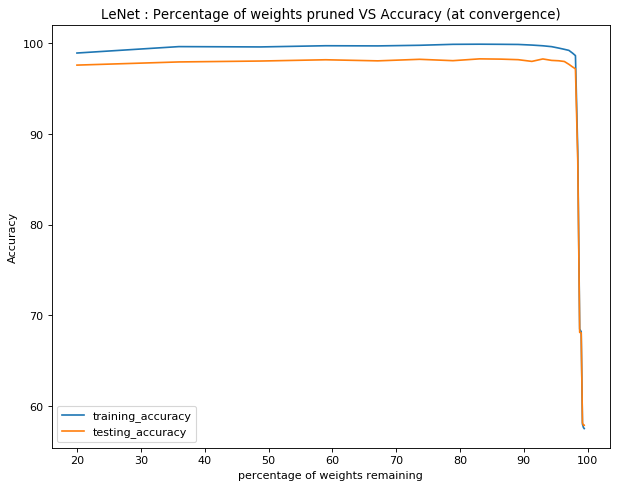

In [10]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("LeNet : Percentage of weights pruned VS Accuracy (at convergence)")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [11]:
# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}

In [12]:
# populate 'plot_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][epoch_length - 1]


In [13]:
# populate 'plot_test_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][epoch_length - 1]


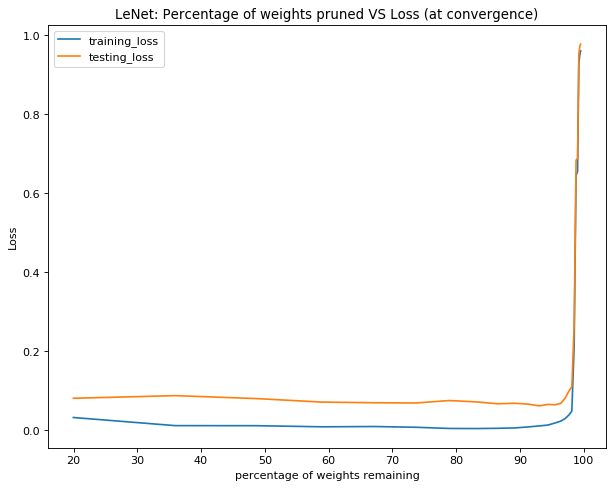

In [14]:
# Visualization of training and testing loss VS percentage of remaining weights-
# pruned-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("LeNet: Percentage of weights pruned VS Loss (at convergence)")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [15]:
# Plot number of epochs (Early Stopping) VS percentage of weights pruned-

# Python 3 dict to hold number of epochs vs % of weights pruned-
plot_num_epochs = {}
plot_num_epochs_test = {}


In [16]:
# populate 'plot_num_epochs'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['accuracy'])
    plot_num_epochs[history_main[k]['percentage_wts_pruned']] = num_epochs


In [ ]:
# populate 'plot_num_epochs_test'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['val_accuracy'])
    plot_num_epochs_test[history[k]['percentage_wts_pruned']] = num_epochs

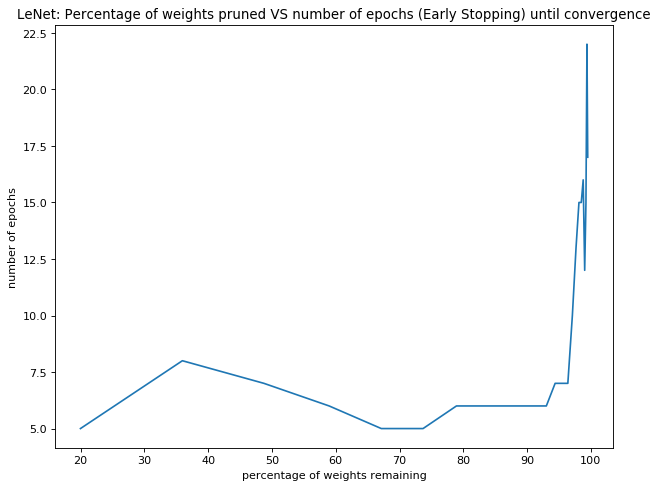

In [17]:
# Visualize percentage of weights remaining VS number of epochs (Early Stopping)
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_num_epochs.keys()), list(plot_num_epochs.values()), label = 'training set')
plt.plot(list(plot_num_epochs_test.keys()), list(plot_num_epochs_test.values()), label = 'testing set')

plt.title("LeNet: Percentage of weights pruned VS number of epochs (Early Stopping) until convergence")
plt.xlabel("percentage of weights remaining")
plt.ylabel("number of epochs")
plt.legend(loc = 'best')
plt.show()


In [18]:
# Try to visualize the STARTING training and testing accuracy VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_accuracy = {}
plot_starting_test_accuracy = {}

# Key:    percentage of weights pruned
# Value:  starting accuracy


In [19]:
# populate 'plot_starting_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][0]


In [20]:
# populate 'plot_starting_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][0]


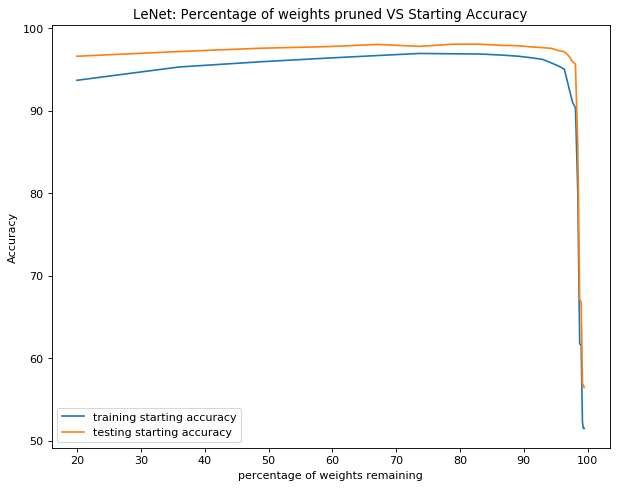

In [21]:
# Visualize starting accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_accuracy.keys()), list(plot_starting_accuracy.values()), label = 'training starting accuracy')
plt.plot(list(plot_starting_test_accuracy.keys()), list(plot_starting_test_accuracy.values()), label = 'testing starting accuracy')

plt.title("LeNet: Percentage of weights pruned VS Starting Accuracy")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [22]:
# Try to visualize the STARTING training and testing loss VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_loss = {}
plot_starting_test_loss = {}

# Key:		percentage of weights pruned
# Value:	starting loss


In [23]:
# Populate 'plot_starting_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][0]


In [24]:
# Populate 'plot_starting_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][0]


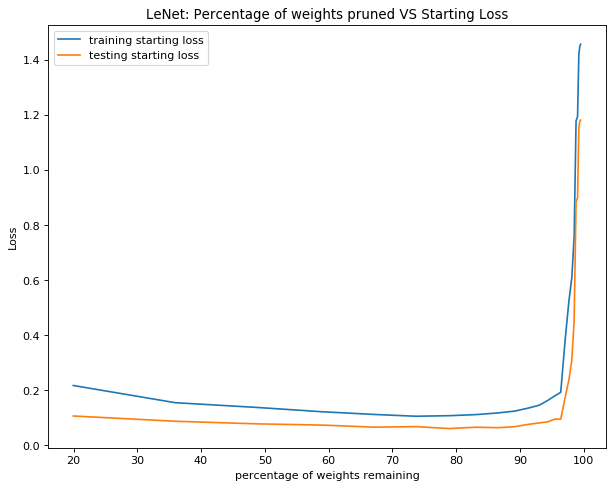

In [25]:
# Visualize Starting training & testing loss VS percentage of weights pruned-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_loss.keys()), list(plot_starting_loss.values()), label = 'training starting loss')
plt.plot(list(plot_starting_test_loss.keys()), list(plot_starting_test_loss.values()), label = 'testing starting loss')

plt.title("LeNet: Percentage of weights pruned VS Starting Loss")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [73]:
# Try to visualize: percentage of weights remaining VS BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		percentage of weights pruned
# Value:	best accuracy

In [74]:
# Populate 'plot_best_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['accuracy'])


In [75]:
# Populate 'plot_best_test_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_test_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['val_accuracy'])


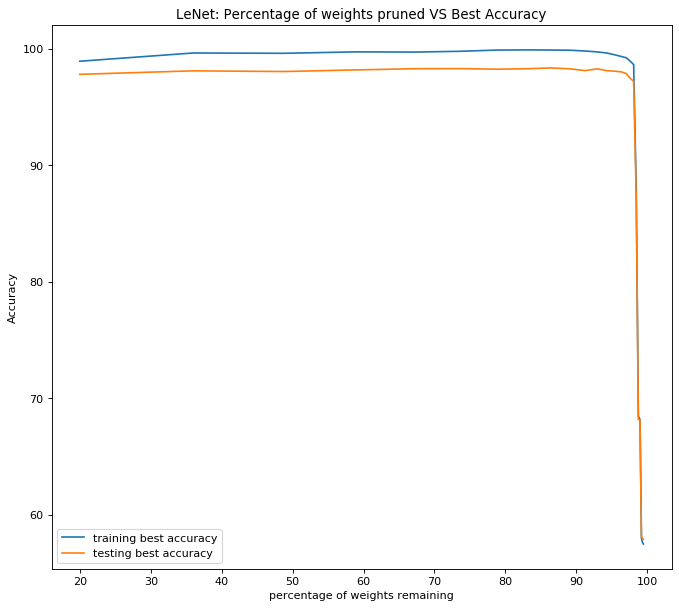

In [76]:
# Visualize best accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'training best accuracy')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'testing best accuracy')

plt.title("LeNet: Percentage of weights pruned VS Best Accuracy")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [77]:
# Try to visualize: percentage of weights remaining VS LOWEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		percentage of weights pruned
# Value:	best loss

In [78]:
# Populate 'plot_best_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['loss'])


In [79]:
# Populate 'plot_best_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_test_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['val_loss'])


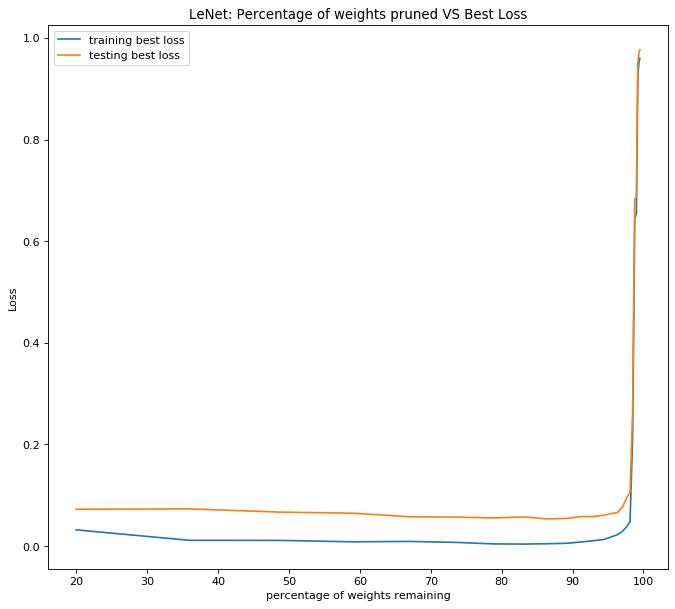

In [80]:
# Visualize best loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'training best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'testing best loss')

plt.title("LeNet: Percentage of weights pruned VS Best Loss")
plt.xlabel("percentage of weights remaining")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()


### Find the iterative pruning round for which training and testing accuracy is highest:

In [81]:
# Find highest training and testing accuracy for all iterative pruning rounds-
best_accuracy = 0
iterative_round = 0


for k in history_main.keys():
	epoch_length = len(history_main[k]['accuracy'])
	if history_main[k]['accuracy'][epoch_length - 1] > best_accuracy:
		best_accuracy = history_main[k]['accuracy'][epoch_length - 1]
		iterative_round = k


print("\nIterative round = {0} has highest training accuracy = {1:.4f}% at percentage of weights pruned = {2:.4f}%\n".format(
    iterative_round, best_accuracy, history_main[iterative_round]['percentage_wts_pruned']))



Iterative round = 8 has highest training accuracy = 99.9183% at percentage of weights pruned = 83.0967%



In [82]:
best_test_accuracy = 0
iterative_round = 0


for k in history_main.keys():
	epoch_length = len(history_main[k]['val_accuracy'])
	if history_main[k]['val_accuracy'][epoch_length - 1] > best_test_accuracy:
		best_test_accuracy = history_main[k]['val_accuracy'][epoch_length - 1]
		iterative_round = k


print("\nIterative round = {0} has highest testing accuracy = {1:.4f}% at percentage of weights pruned = {2:.4f}%\n".format(
    iterative_round, best_test_accuracy, history_main[iterative_round]['percentage_wts_pruned']))



Iterative round = 8 has highest testing accuracy = 98.3000% at percentage of weights pruned = 83.0967%



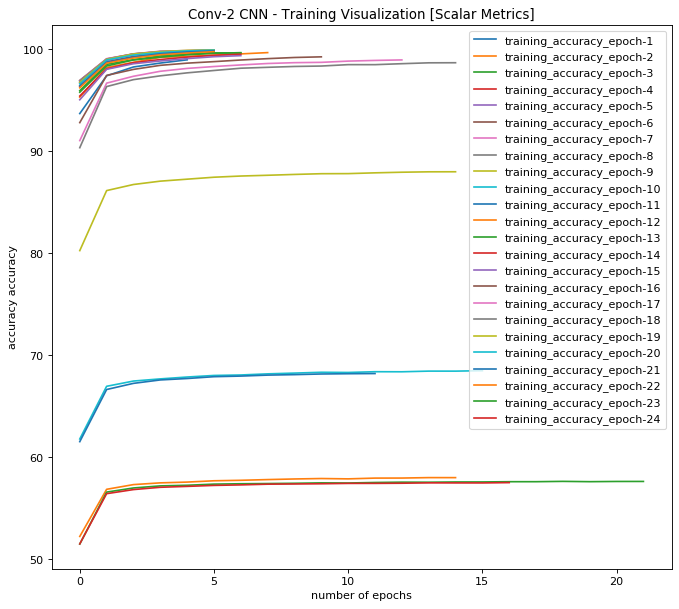

In [83]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for k in history_main.keys():
    plt.plot(history_main[k]['accuracy'], label = 'training_accuracy_epoch-{0}'.format(k))
    # plt.plot(history_main[k]['val_accuracy'], label = 'testing_accuracy_epoch-{0}'.format(k))

plt.title("Conv-2 CNN - Training Visualization [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("accuracy accuracy")
plt.legend(loc = 'best')
plt.show()

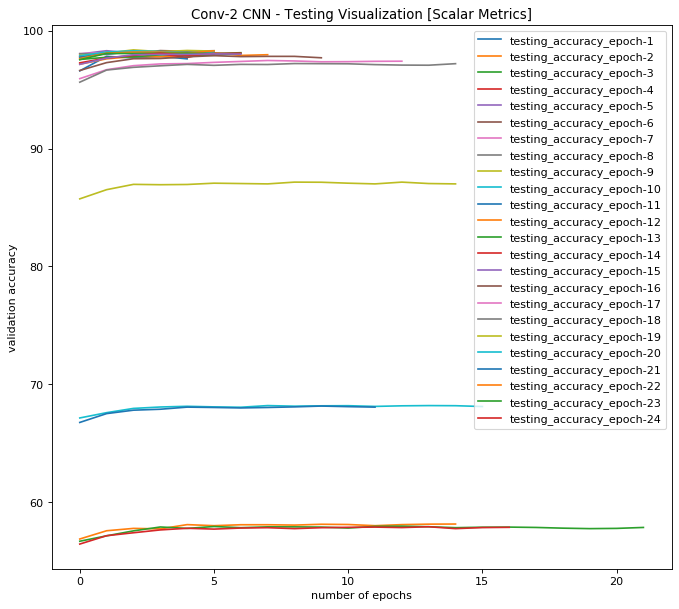

In [84]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for k in history_main.keys():
    # plt.plot(history_main[k]['accuracy'], label = 'training_accuracy_epoch-{0}'.format(k))
    plt.plot(history_main[k]['val_accuracy'], label = 'testing_accuracy_epoch-{0}'.format(k))

plt.title("Conv-2 CNN - Testing Visualization [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("validation accuracy")
plt.legend(loc = 'best')
plt.show()